In [2]:
import sys
sys.path.append("../")

import torch, os
import numpy as np
from PIL import Image
from huggingface_hub import snapshot_download
from diffusers import StableDiffusionImg2ImgPipeline
from converter import load_wav, mel_spectrogram, normalize_spectrogram, denormalize_spectrogram, Generator, get_mel_spectrogram_from_audio
from utils import pad_spec, image_add_color, torch_to_pil, normalize, denormalize
from IPython.display import display, Audio

In [3]:
pretrained_model_name_or_path = "auffusion/auffusion-full-no-adapter"
dtype = torch.float16
device = "cuda"

In [ ]:
if not os.path.isdir(pretrained_model_name_or_path):
    pretrained_model_name_or_path = snapshot_download(pretrained_model_name_or_path) 

In [4]:
vocoder = Generator.from_pretrained(pretrained_model_name_or_path, subfolder="vocoder")
vocoder = vocoder.to(device=device, dtype=dtype)

In [ ]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=dtype)
pipe = pipe.to(device)

In [14]:
# Examples
audio_path = "examples/img2img/YniwgMbB6tpQ_01.wav"
width_start, width = 0, 160
strength_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7]
prompt = "A cat is moewing"
seed = 42

audio_path = "examples/img2img/_GI7meqlYZk_30.wav"
width_start, width = 800, 160
strength_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7]
prompt = "A racing car"
seed = 42

audio_path = "examples/img2img/GIOApFAWDOc_160.wav"
width_start, width = 0, 160
strength_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7]
prompt = "aumbulance siren"
seed = 41

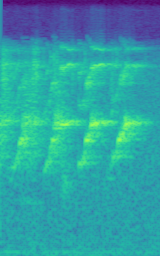

In [15]:
# Loading
audio, sampling_rate = load_wav(audio_path)
audio, spec = get_mel_spectrogram_from_audio(audio)
norm_spec = normalize_spectrogram(spec)
norm_spec = norm_spec[:,:, width_start:width_start+width]
norm_spec = pad_spec(norm_spec, 1024)
norm_spec = normalize(norm_spec) # normalize to [-1, 1], because pipeline do not normalize for torch.Tensor input

raw_image = image_add_color(torch_to_pil(norm_spec[:,:,:width]))
display(raw_image)

In [ ]:
# Generation for different strength
image_list = []
audio_list = []

generator = torch.Generator(device=device).manual_seed(seed)

for strength in strength_list:
    with torch.autocast("cuda"):
        output_spec = pipe(
            prompt=prompt, image=norm_spec, num_inference_steps=100, generator=generator, output_type="pt", strength=strength, guidance_scale=7.5
        ).images[0]

    # add to image_list
    output_spec = output_spec[:, :, :width]
    output_spec_image = torch_to_pil(output_spec)
    color_output_spec_image = image_add_color(output_spec_image)
    image_list.append(color_output_spec_image)

    # add to audio_list
    denorm_spec = denormalize_spectrogram(output_spec)
    denorm_spec_audio = vocoder.inference(denorm_spec)
    audio_list.append(denorm_spec_audio)

audio_path: examples/img2img/GIOApFAWDOc_160.wav
width_start: 0 width: 160
text prompt: aumbulance siren
strength_list: [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7]


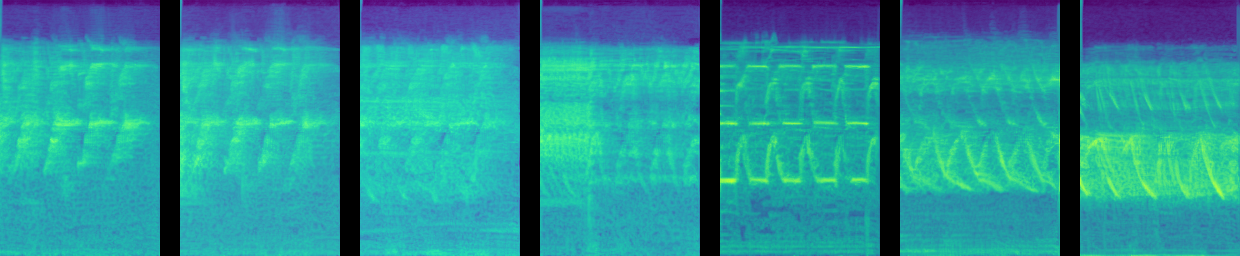

In [17]:
# Display

# Concat image with different strength & add interval between images with black color 
concat_image_list = []
for i in range(len(image_list)):
    if i == len(image_list) - 1:
        concat_image_list.append(np.array(image_list[i]))
    else:
        concat_image_list.append(np.concatenate([np.array(image_list[i]), np.ones((256, 20, 3))*0], axis=1))

concat_image = np.concatenate(concat_image_list, axis=1)
concat_image = Image.fromarray(np.uint8(concat_image))

### Concat audio
concat_audio_list = [np.concatenate([audio, np.zeros((1, 16000))], axis=1) for audio in audio_list]
concat_audio = np.concatenate(concat_audio_list, axis=1)

print("audio_path:", audio_path)
print("width_start:", width_start, "width:", width)
print("text prompt:", prompt)
print("strength_list:", strength_list)
display(Audio(concat_audio, rate=16000))
display(concat_image)    